# Week 1 Lab: Exploring the Earth as Data

---

**Objective:** Develop an intuitive understanding of spectral imagery by visualizing and analyzing Sentinel-2 data for one of the course case study regions using the GEE Python API.

### 1. Setup and Authentication

First, we need to install the necessary libraries and authenticate with Google Earth Engine. If you have already installed these libraries, you can skip the installation step.

In [12]:
#!pip install earthengine-api geemap matplotlib

In [13]:
import ee
import geemap
import matplotlib.pyplot as plt
import json

# Initialize Earth Engine (auth if needed)
try:
    ee.Initialize()
    print('Earth Engine initialized')
except Exception as e:
    print('EE init failed, attempting auth...')
    ee.Authenticate()
    ee.Initialize()
    print('Earth Engine authenticated and initialized')

Earth Engine initialized


### 2. Define Region of Interest (AOI)

Now, let's define our region of interest. We will use the coordinates for the Los Lagos region in Chile, but feel free to choose another case study area. You can use a tool like [geojson.io](http://geojson.io/) to get the coordinates for your desired AOI.

In [14]:
# Load AOI from GeoJSON at data/external/aoi.geojson
from pathlib import Path
import geopandas as gpd

AOI_PATH = Path('../data/external/aoi.geojson')
aoi_gdf = gpd.read_file(AOI_PATH)
if aoi_gdf.crs is None:
    aoi_gdf.set_crs(epsg=4326, inplace=True)

aoi_geojson = json.loads(aoi_gdf.to_crs(epsg=4326).to_json())
coords = aoi_geojson['features'][0]['geometry']
AOI_EE = ee.Geometry(coords)
print('AOI loaded from', AOI_PATH)
print('AOI bounds (EPSG:4326):', aoi_gdf.to_crs(epsg=4326).total_bounds)

AOI loaded from ../data/external/aoi.geojson
AOI bounds (EPSG:4326): [-73.107147 -41.15074  -73.006725 -41.091255]


### 3. Load Sentinel-2 Imagery

Next, we will search for a recent, cloud-free Sentinel-2 image for our AOI. We will filter the image collection by date and cloud cover, and then select the first image in the collection.

In [15]:
image = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(AOI_EE)
    .filterDate('2023-01-01', '2023-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .sort('CLOUDY_PIXEL_PERCENTAGE')
    .first()
)
print('Selected image date:', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo())

Selected image date: 2023-02-02


### 4. Visualize Band Combinations

Let's visualize the image using different band combinations. We will create a true color composite (RGB) and a false color composite (NIR, Red, Green).

In [16]:
rgb_vis_params = {'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2']}
false_color_vis_params = {'min': 0, 'max': 3000, 'bands': ['B8', 'B4', 'B3']}

map = geemap.Map()
map.centerObject(AOI_EE, 11)
map.addLayer(AOI_EE, {'color': 'yellow'}, 'AOI')
map.addLayer(image, rgb_vis_params, 'True Color (RGB)')
map.addLayer(image, false_color_vis_params, 'False Color (NIR-R-G)')
map

Map(center=[-41.12100390698603, -73.05693600000197], controls=(WidgetControl(options=['position', 'transparent…

### 5. Calculate Spectral Indices

Now, let's calculate the Normalized Difference Vegetation Index (NDVI) and the Normalized Difference Water Index (NDWI). These indices will help us highlight vegetation and water bodies in the image.

In [17]:
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

ndvi_vis_params = {'min': -0.2, 'max': 0.8, 'palette': ['blue', 'white', 'green']}
ndwi_vis_params = {'min': -0.5, 'max': 0.5, 'palette': ['brown', 'white', 'blue']}
ndbi_vis_params = {'min': -0.5, 'max': 0.5, 'palette': ['green', 'white', 'gray']}

map.addLayer(ndvi, ndvi_vis_params, 'NDVI')
map.addLayer(ndwi, ndwi_vis_params, 'NDWI')
map.addLayer(ndbi, ndbi_vis_params, 'NDBI')
map

Map(center=[-41.12100390698603, -73.05693600000197], controls=(WidgetControl(options=['position', 'transparent…

### 6. Create a Composite Visualization

Finally, let's create a 2x2 panel visualization to compare the different views of our AOI. We will use `matplotlib` to create the plot and `geemap` to get the thumbnail images.

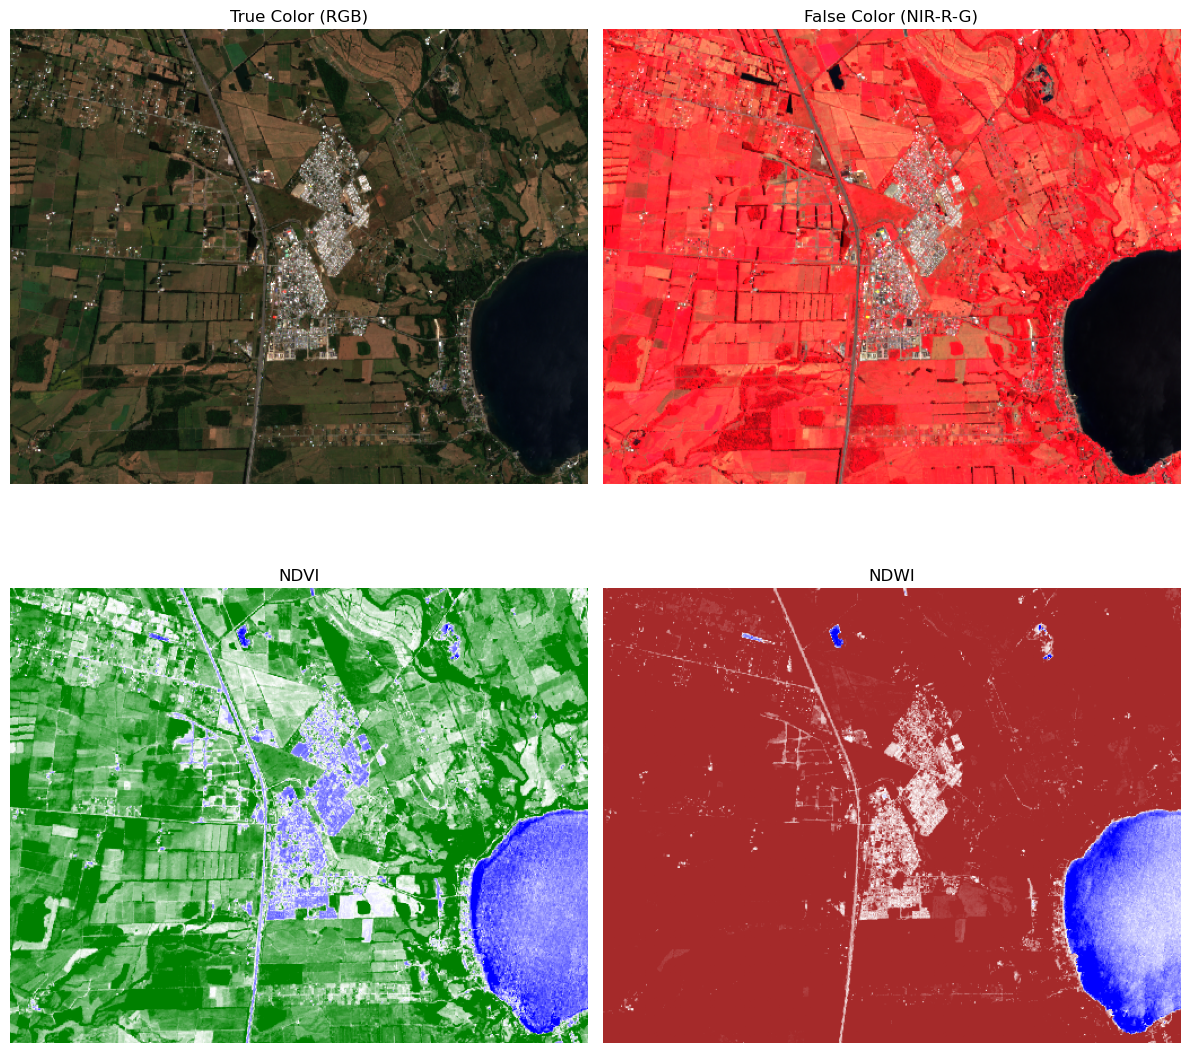

In [18]:
# Simple and robust 2x2 composite: save thumbnails to disk, read with plt.imread

import os
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

tmpdir = tempfile.gettempdir()
rgb_path   = os.path.join(tmpdir, 'thumb_rgb.png')
false_path = os.path.join(tmpdir, 'thumb_false.png')
ndvi_path  = os.path.join(tmpdir, 'thumb_ndvi.png')
ndwi_path  = os.path.join(tmpdir, 'thumb_ndwi.png')

# Save thumbnails (ignore return values)
geemap.get_image_thumbnail(image, rgb_path,   vis_params=rgb_vis,   region=AOI_EE, dimensions=512, format='png')
geemap.get_image_thumbnail(image, false_path, vis_params=false_vis, region=AOI_EE, dimensions=512, format='png')
geemap.get_image_thumbnail(ndvi,  ndvi_path,  vis_params=ndvi_vis,  region=AOI_EE, dimensions=512, format='png')
geemap.get_image_thumbnail(ndwi,  ndwi_path,  vis_params=ndwi_vis,  region=AOI_EE, dimensions=512, format='png')

# Read PNGs as arrays for imshow
rgb_img   = mpimg.imread(rgb_path)
false_img = mpimg.imread(false_path)
ndvi_img  = mpimg.imread(ndvi_path)
ndwi_img  = mpimg.imread(ndwi_path)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0, 0].imshow(rgb_img);   axes[0, 0].set_title('True Color (RGB)');      axes[0, 0].axis('off')
axes[0, 1].imshow(false_img); axes[0, 1].set_title('False Color (NIR-R-G)'); axes[0, 1].axis('off')
axes[1, 0].imshow(ndvi_img);  axes[1, 0].set_title('NDVI');                  axes[1, 0].axis('off')
axes[1, 1].imshow(ndwi_img);  axes[1, 1].set_title('NDWI');                  axes[1, 1].axis('off')
plt.tight_layout()
plt.savefig('../figures/week1_composite.png', dpi=300, bbox_inches='tight')
plt.show()

🖼️ Top Left – True Color (RGB)
	•	Bands used: Red, Green, Blue
	•	What it shows: This simulates what the human eye sees — a natural‐color image.
	•	Interpretation:
	•	Vegetation appears green,
	•	Urban areas (roads, rooftops) look light gray or white,
	•	The lake appears dark blue to black, since water absorbs most visible light,
	•	Agricultural fields show a patchwork of green (active crops) and brown (bare soil or harvested areas).
	•	Purpose: Good for visual familiarity but limited in analytical value since vegetation and soil can look similar depending on illumination.

⸻

🌾 Top Right – False Color Composite (NIR–R–G)
	•	Bands used: Near Infrared (NIR) → Red channel, Red → Green channel, Green → Blue channel
	•	What it shows: Highlights vegetation in bright red tones because vegetation strongly reflects NIR.
	•	Interpretation:
	•	Healthy vegetation → bright red
	•	Urban/built-up areas → light gray or cyan
	•	Bare soil or dry fields → dull pink to brown
	•	Water bodies → very dark or black (NIR absorbed)
	•	Purpose: Excellent for assessing vegetation vigor and identifying water or built-up surfaces.

⸻

🌱 Bottom Left – NDVI (Normalized Difference Vegetation Index)
	•	Equation: (NIR – Red) / (NIR + Red)
	•	What it shows: Relative vegetation greenness and density.
	•	Interpretation:
	•	Bright green areas → high NDVI (dense, healthy vegetation)
	•	Pale green/gray → sparse vegetation or fallow fields
	•	Blue/purple areas (low or negative NDVI) → non-vegetated surfaces such as urban areas and water
	•	Purpose: Quantifies vegetation health and land cover types.
You can clearly distinguish forests, croplands, and urban patches.

⸻

💧 Bottom Right – NDWI (Normalized Difference Water Index)
	•	Equation: (Green – NIR) / (Green + NIR)
	•	What it shows: Surface water and wetness levels.
	•	Interpretation:
	•	Blue areas → high NDWI (open water or saturated soil)
	•	Brown/red areas → low NDWI (dry land or built-up areas)
	•	Observation:
	•	The lake shows very bright blue — strong positive NDWI confirming open water.
	•	Minor blue patches near the city could indicate ponds, reservoirs, or flooded fields.
	•	Purpose: Isolates surface water and monitors seasonal changes or flooding.

### 7. Reflection

Answer the following questions in your `Week1_Reflection.md` file:

1. What patterns did you observe in the different band combinations and spectral indices? How did they differ from each other?
2. What do you think are the main advantages and disadvantages of using satellite imagery for environmental monitoring?
3. How might the resolutions (spatial, temporal, spectral) of the satellite imagery affect your ability to answer specific environmental questions?